In [134]:
#!/usr/bin/python
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### external codes
from redTools import *
from Kcorrect import *
  
########################################################### Begin

inFile  = 'ESN_HI_catal.csv'   # input catalog
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

## purifying input data
index, = np.where(table['Sba']>0.01)
table = trim(table, index)

index, = np.where(table['Wba']>0.01)
table = trim(table, index)

Sba = table['Sba']  # SDSS b/a
Wba = table['Wba']  # WISE b/a


## SDSS vs. WISE axial ratios

Since WISE images have a larger point spread function (PSF) compared to those of SDSS, users might have chosen larger axial ratios *(b/a)* to ease up the photometry of WISE images. *a* and *b* are semi-major and semi-minor axes of the elliptical photometry aperture. The larger the PSF is the larger *b* gets relative to *a*.
If galaxies are more face-on, i.e. larger *b/a*, the PSF effect gets smaller, since the PSF usually has a round Gaussian shape. As seen in the below diagram, the axial ratio of circular galaxies are less affected by PSF and normally the same apertures are used for both SDSS and WISE photometry.  

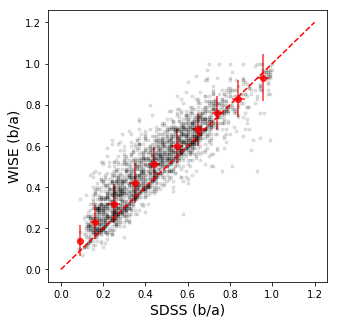

In [135]:
fig = plt.figure(figsize=(5, 5))
plt.plot(Sba,Wba, 'k.', alpha=0.1)  # black points
plt.plot([0,1.2],[0,1.2], 'r--')    # equality red line
plt.xlabel('SDSS (b/a)', size=14)
plt.ylabel('WISE (b/a)', size=14)


for i in np.arange(0,1,0.1):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.1:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        ## red points
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)


In [136]:
from astropy.stats import sigma_clip

## function definition to reject outliers
def sigmaClip(X, Y, sigma=2, iters=5, range_=[0,1,0.05]):
    x_ = []
    y_ = []

    x_ = np.asarray(x_)
    y_ = np.asarray(y_)
    
    a = range_[0]
    b = range_[1]
    d = range_[2]

    for i in np.arange(a,b,d):

        x = []
        y = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+d:
                x.append(xi)
                y.append(Y[ii])
        if len(x)>0:
            y = np.asarray(y)
            x = np.asarray(x)
            filtered_data = sigma_clip(y, sigma=sigma, iters=iters, copy=False)
            y = filtered_data.data[np.logical_not(filtered_data.mask)]
            x = x[np.logical_not(filtered_data.mask)]

            x_ = np.concatenate((x_, x))
            y_ = np.concatenate((y_, y))
    return x_, y_


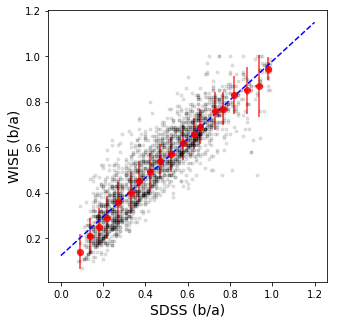

In [137]:
## Getting rid of outliers bin by bin
Sba, Wba = sigmaClip(Sba, Wba, sigma=4, iters=5)

fig = plt.figure(figsize=(5, 5))
plt.plot(Sba,Wba, 'k.', alpha=0.1)
#plt.plot([0,1.2],[0,1.2], 'r--')
plt.xlabel('SDSS (b/a)', size=14)
plt.ylabel('WISE (b/a)', size=14)


for i in np.arange(0,1,0.05):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

############################################# Geting rid of outliers
a0, b0  = np.polyfit(Sba, Wba, 1)
x = np.linspace(0,1.2,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################

## Comparing Half light Radii (R<sub>e</sub>)

This is an attempt to estimate the *W1* half-light radii from the *i* band values. 
Bulges of galaxies are more luminous at a larger wavelength because they are formed by red and dead stars which appear to be yellower/redder. Therefore, we expect that at larger wavelengths half-light radii to be smaller due to the more flux contribution from the bulge of galaxies.

Text(0,0.5,'$R_e$ WISE [arcmin]')

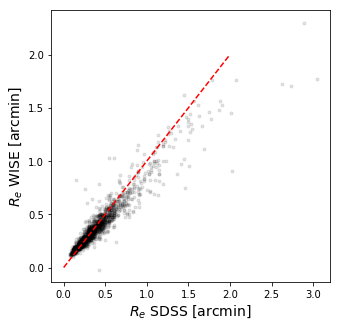

In [138]:
### Ri is the infrared half light radius
### Ro is the optical half light radius

#Ri = (table['R50_w1']+table['R50_w2'])/2.
Ri = table['R50_w1']
#Ro = (table['R50_g']+table['R50_r']+table['R50_i'])/3.
Ro = table['R50_i']
      
fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE [arcmin]', size=14)

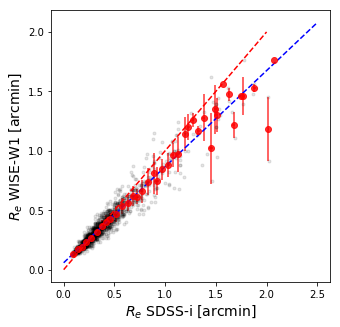

In [139]:
Ro, Ri = sigmaClip(Ro, Ri, sigma=3, iters=5, range_=[0,2.5,0.1])

fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS-i [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE-W1 [arcmin]', size=14)

for i in np.arange(0,2.5,0.05):
    
    x = []
    y = []
    for ii in range(len(Ro)):
        xi = Ro[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Ri[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

#############################################
a0, b0  = np.polyfit(Ro, Ri, 1)
x = np.linspace(0,2.5,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################